In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path

In [85]:
DATA_DIR = Path('data')
SUDOKUS = DATA_DIR / 'sudokus'

train_ids = set(f.name.rstrip('.jpg') for f in (SUDOKUS / 'v2_train').glob('*.jpg'))

locs = pd.read_csv(SUDOKUS / 'outlines_sorted.csv', sep=',')
locs['image_id'] = locs['filepath'].str.split('/').str[-1].str.rstrip('.jpg')
locs = locs[locs['image_id'].isin(train_ids)]
locs = locs.set_index('image_id', drop=True)
locs = locs.drop(columns=['filepath'])
locs.head()

,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
image_id,,,,,,,,
aug_image72_0,142.596170,117.519953,446.098222,131.956986,437.876923,424.527039,131.374176,421.166265
aug_image33_1,233.815881,115.001909,561.684173,130.318583,560.823422,405.328300,214.678729,396.270681
aug_image184_2,139.241189,177.535315,425.234037,127.382283,461.318723,357.602647,184.966984,410.775002
aug_image65_3,158.887904,134.987574,401.935329,123.522731,417.501810,324.337894,164.944020,341.814570
aug_image1022_4,361.060913,552.575187,761.332906,560.132801,751.175094,966.429355,340.020881,955.035583


In [86]:
locs.describe()

,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,149.087222,138.623868,535.264279,139.206993,540.098835,505.749082,146.599535,509.469905
std,79.718804,125.679977,148.604924,123.821807,151.378050,225.423963,78.821079,225.300557
min,5.742020,0.000000,296.010811,0.000000,308.757719,274.927868,1.000000,268.768315
25%,92.000000,56.888950,435.440624,58.089589,438.674946,366.014850,91.250000,369.454418
50%,144.110600,105.201304,494.101218,105.251328,498.187054,412.532129,140.498334,417.789840
75%,196.386748,164.232030,571.750000,163.088335,580.971086,467.300382,193.406274,472.000000
max,525.737831,606.801215,1202.000000,585.974643,1220.916939,1246.000000,473.553249,1240.000000


In [87]:
from matplotlib.patches import Rectangle
from PIL import ImageOps


def get_image(image_id):
    img_path = SUDOKUS / 'v2_train' / f'{image_id}.jpg'
    img = Image.open(img_path)
    ImageOps.exif_transpose(img, in_place=True)
    return img

def get_bbox(image_id):
    corners = np.array(locs.loc[image_id]).reshape((4, 2))
    return corners

def plot_img(img, corners: np.ndarray):
    if np.all(corners < 1.0): corners *= 224
    corners = np.round(corners)
    corners = np.concatenate((corners, corners[0]), axis=None).reshape((-1, 2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.plot(corners[:, 0], corners[:, 1], color='r', linewidth=2)

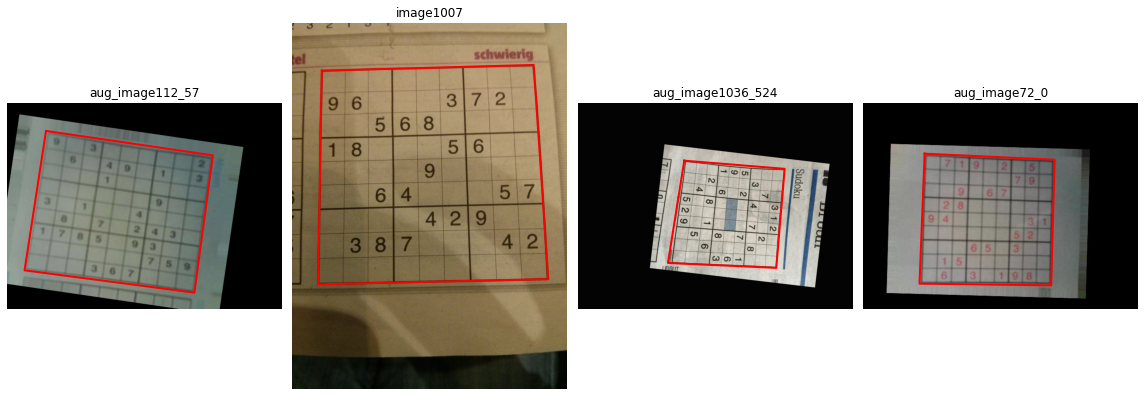

In [88]:
ixs = np.random.choice(len(locs), size=3, replace=False).tolist() + [0]

plt.figure(figsize=(16, 10))
for i, image_id in enumerate(locs.iloc[ixs].index):
    plt.subplot(1, 4, i+1)
    plt.title(image_id)
    img = get_image(image_id)
    corners = get_bbox(image_id)
    plot_img(img, corners)
plt.tight_layout();

In [89]:
def preprocess(img: Image.Image, bbox=None):
    scalex, scaley = 224 / img.width, 224 / img.height
    img = img.convert('L')
    img = img.resize((224, 224))
    img = np.array(img) / 255
    if bbox is not None:
        bbox = bbox.reshape((-1, 2)) * [scalex, scaley] / 224
    return img, bbox

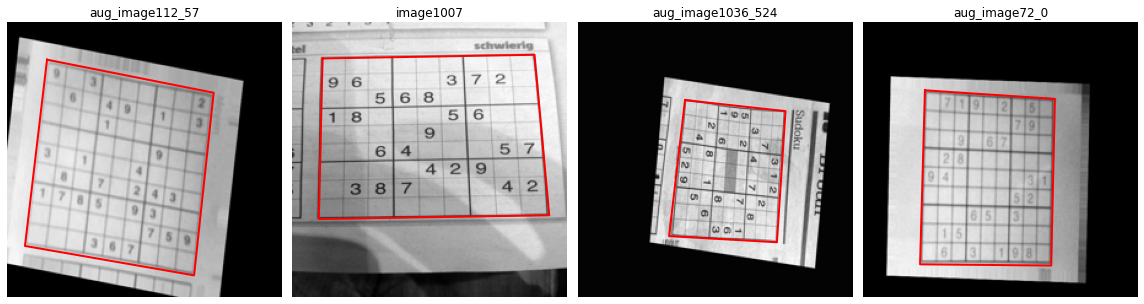

In [90]:
plt.figure(figsize=(16, 10))
for i, image_id in enumerate(locs.iloc[ixs].index):
    plt.subplot(1, 4, i+1)
    plt.title(image_id)
    img = get_image(image_id)
    corners = get_bbox(image_id)
    plot_img(*preprocess(img, corners))
plt.tight_layout();

In [91]:
images, bboxes = [], []
for image_id in locs.index:
    img, corners = preprocess(get_image(image_id), get_bbox(image_id))
    images.append(img)
    bboxes.append(corners.reshape(4*2))

images = np.stack(images)
print(f'Image values:\n\tmean: {images.mean()}\n\tstd: {images.std()}')

bboxes = pd.DataFrame(
    bboxes, 
    columns=[f'{"x" if i % 2 == 0 else "y"}{i//2}'for i in range(4*2)]
)
bboxes.head()

Image values:
	mean: 0.34164717205133155
	std: 0.2734562587803735


,x0,y0,x1,y1,x2,y2,x3,y3
0,0.222807,0.244833,0.697028,0.274910,0.684183,0.884431,0.205272,0.877430
1,0.365337,0.239587,0.877632,0.271497,0.876287,0.844434,0.335436,0.825564
2,0.217564,0.369865,0.664428,0.265380,0.720811,0.745006,0.289011,0.855781
3,0.248262,0.281224,0.628024,0.257339,0.652347,0.675704,0.257725,0.712114
4,0.376105,0.431699,0.793055,0.437604,0.782474,0.755023,0.354188,0.746122


In [92]:
bboxes.describe()

,x0,y0,x1,y1,x2,y2,x3,y3
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000
mean,0.206484,0.195731,0.738002,0.197966,0.744297,0.797043,0.202975,0.803928
std,0.098942,0.109853,0.101055,0.107275,0.102313,0.102872,0.097722,0.105875
min,0.008972,0.000000,0.462517,0.000000,0.482434,0.491375,0.001042,0.519026
25%,0.132047,0.111780,0.663133,0.113885,0.671327,0.720106,0.130165,0.723052
50%,0.209891,0.197579,0.738715,0.201539,0.743802,0.797322,0.201076,0.803972
75%,0.278036,0.275947,0.812828,0.274261,0.816148,0.877066,0.274247,0.889774
max,0.452842,0.474063,0.996219,0.457793,0.991478,0.999066,0.489140,0.999265


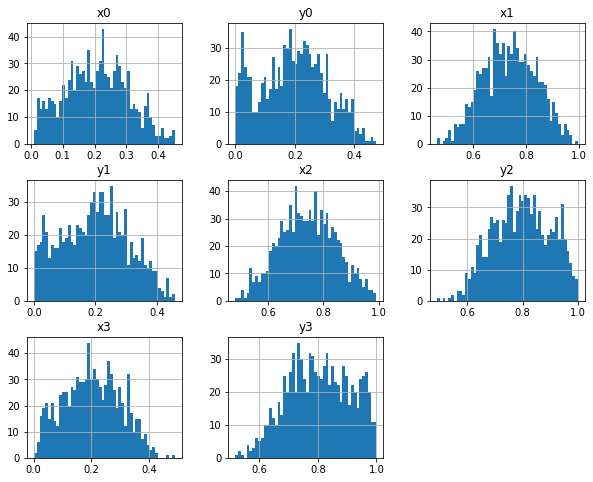

In [93]:
bboxes.hist(figsize=(10,8), bins=50);